In [131]:
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
from IPython.display import display, clear_output, Audio
%matplotlib inline
plt.rcParams['figure.dpi']= 150

First, we define parameters:

In [132]:
# Transport parameters
s_perm = 0.1
u_perm_val = 0.1
w_D_perm = 0.1
w_C_perm = 0.1
S_input = 0.1
U_input = 1
osm_input = 2
u_frac = 1
s_dump = 0

# discretization
N = 10
dx = 1/N

Now, we define the difference quotient operator

In [133]:
def diff_x(y): 
    n = len(y)-1
    diff = np.zeros(n)
    for l in range(n):
        diff[l] = (y[l+1]-y[l])/dx
    
    return diff

def avg(y):
    n = len(y)-1
    average = np.zeros(n)
    for l in range(n):
        average[l] = (y[l+1]+y[l])/2
    
    return average

In [149]:
def res(y):
    S = y[:(N+1)].copy()
    U = y[(N+1):2*(N+1)].copy()
    q_D = y[2*(N+1):3*(N+1)].copy()
    q_C = y[3*(N+1):4*(N+1)].copy()
    q_A = y[4*(N+1):5*(N+1)].copy()
    q_out = y[5*(N+1):6*(N+1)].copy()
    S_avg = avg(S)
    U_avg = avg(U)
    q_D_avg = avg(q_D)
    q_C_avg = avg(q_C)
    q_A_avg = avg(q_A)
    q_out_avg = avg(q_out)

    # if s_dump>0:
    S_0 = np.zeros(N)
    for l in range(N):
        S_0[l] = S[-1] - S_avg[l] - s_dump*(1-(l+0.5)*dx)
    # elif s_dump==0.0:
    #     S_0 = S[-1] - S_avg
    U_0 = U[-1] - U_avg
    q_0 = q_out_avg - q_C_avg - q_A_avg - q_D_avg

    u_perm = np.zeros(N)
    for l in range(N):
        perm_grids = u_frac*N
        insul = np.floor(N-perm_grids)
        if l==insul:
            u_perm[l] = u_perm_val*(perm_grids - np.ceil(perm_grids-1))
        elif l>insul:
            u_perm[l] = u_perm_val

    residue = np.zeros(6*(N+1))
    res_s = residue[:(N+1)]
    res_u = residue[(N+1):2*(N+1)]
    res_D = residue[2*(N+1):3*(N+1)]
    res_C = residue[3*(N+1):4*(N+1)]
    res_A = residue[4*(N+1):5*(N+1)]
    res_out = residue[5*(N+1):6*(N+1)]

    res_s[0] = S[-1] + S_input
    res_s[1:] = diff_x(S) + s_perm*(
        (S_avg/q_A_avg) - (S_0/q_0)
    )
    res_u[0] = U[0] - U_input
    res_u[1:] = diff_x(U) + u_perm*(
        (U_avg/q_C_avg) - (U_0/q_0)
    )
    res_D[0] = q_D[0] - 2*S_input/osm_input
    res_D[1:] = diff_x(q_D) + w_D_perm*(
        (2*S_0 + U_0)/q_0 - 2*S_input/q_D_avg 
    )
    res_C[0] = q_C[0] - U_input/osm_input
    res_C[1:] = diff_x(q_C) + w_C_perm*(
        (2*S_0 + U_0)/q_0 - U_avg/q_C_avg 
    )
    res_A[0] = q_A[-1] + q_D[-1]
    res_A[1:] = diff_x(q_A)
    res_out[0] = q_C[-1] - q_out[-1]
    res_out[1:] = diff_x(q_out)

    return residue

In [ ]:
N=50
dx=1/N
y = np.load('./4fluxes_1nephron_max.npy')
S = y[:(N+1)]
U = y[(N+1):2*(N+1)]
q_D = y[2*(N+1):3*(N+1)]
q_C = y[3*(N+1):4*(N+1)]
q_A = y[4*(N+1):5*(N+1)]
q_out = y[5*(N+1):6*(N+1)]

y_init = np.zeros(6*(N+1))
S_init = y_init[:(N+1)]
U_init = y_init[(N+1):2*(N+1)]
q_D_init = y_init[2*(N+1):3*(N+1)]
q_C_init = y_init[3*(N+1):4*(N+1)]
q_A_init = y_init[4*(N+1):5*(N+1)]
q_out_init = y_init[5*(N+1):6*(N+1)]

y_init[:] = y.copy()

output_osm_0 = np.zeros(10)
output_osm_C = np.zeros(10)
output_osm_D = np.zeros(10)

# Transport parameters
s_perm = 1.2
u_perm_val = 1.2
w_D_perm = 10
w_C_perm = 10
S_input = 0.8
U_input = 2
osm_input = 2

for n in range(10):
    u_frac = 1 - 0.1*n

    y[:] = fsolve(res,y_init,maxfev=500*6*(N+1))
    q_0 = avg(q_out) - avg(q_C) - avg(q_A) - avg(q_D)
    S_0 = S[-1] - avg(S)
    U_0 = U[-1] - avg(U)
    output_osm_0[9-n] = (2*S_0[-1]+U_0[-1])/q_0[-1]
    output_osm_C[9-n] = U[-1]/q_C[-1]
    output_osm_D[9-n] = 2*S_input/q_D[-1]

<function matplotlib.pyplot.show(close=None, block=None)>

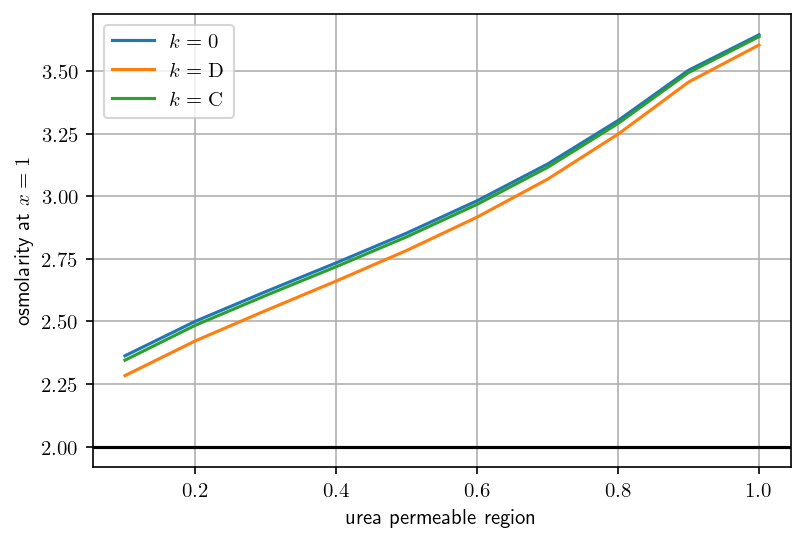

In [ ]:
# Plotting osmolarity
n = np.linspace(0.1,1.0,num=10)
compartments = ['0','\mathrm{D}','\mathrm{C}']
osm = [output_osm_0,output_osm_C,output_osm_D]

fig, ax = plt.subplots()
plt.rcParams['text.usetex'] = True
ax.grid(True, which='both')
ax.axhline(y=2, color='k')
for k in range(3):
    ax.plot(n,osm[k],label=r'$k={}$'.format(compartments[k]))
ax.legend()
plt.xlabel(r"urea permeable region")
plt.ylabel(r"osmolarity at $x=1$")
plt.show

In [ ]:
y[:] = np.load('./4fluxes_1nephron_max.npy')

output_osm_0 = np.zeros(58)
output_osm_C = np.zeros(58)
output_osm_D = np.zeros(58)

# Transport parameters
s_perm = 1.2
u_perm_val = 1.2
w_D_perm = 10
w_C_perm = 10
S_input = 0.8
U_input = 2
osm_input = 2
u_frac = 1
for n in range(58):
    y_init[:] = y.copy()
    s_dump = 0 + n*0.0005

    y[:] = fsolve(res,y_init,maxfev=500*6*(N+1))
    q_0 = avg(q_out) - avg(q_C) - avg(q_A) - avg(q_D)
    S_0 = S[-1] - avg(S)
    U_0 = U[-1] - avg(U)
    output_osm_0[n] = (2*S_0[-1]+U_0[-1])/q_0[-1]
    output_osm_C[n] = U[-1]/q_C[-1]
    output_osm_D[n] = 2*S_input/q_D[-1]

In [ ]:
y[:] = np.load('./4fluxes_1nephron_max.npy')

bw_osm_0 = np.zeros(58)
bw_osm_C = np.zeros(58)
bw_osm_D = np.zeros(58)

# Transport parameters
s_perm = 1.2
u_perm_val = 1.2
w_D_perm = 10
w_C_perm = 10
S_input = 0.8
U_input = 2
osm_input = 2
u_frac = 1
for n in range(58):
    if n==1:
        y_init[:]=np.load('./4fluxes_1nephron_max.npy')
    else:
        y_init[:] = y.copy()
    
    s_dump = 0.0285 - n*0.0005

    y[:] = fsolve(res,y_init,maxfev=500*6*(N+1))
    q_0 = avg(q_out) - avg(q_C) - avg(q_A) - avg(q_D)
    S_0 = S[-1] - avg(S)
    U_0 = U[-1] - avg(U)
    bw_osm_0[57-n] = (2*S_0[-1]+U_0[-1])/q_0[-1]
    bw_osm_C[57-n] = U[-1]/q_C[-1]
    bw_osm_D[57-n] = 2*S_input/q_D[-1]

<function matplotlib.pyplot.show(close=None, block=None)>

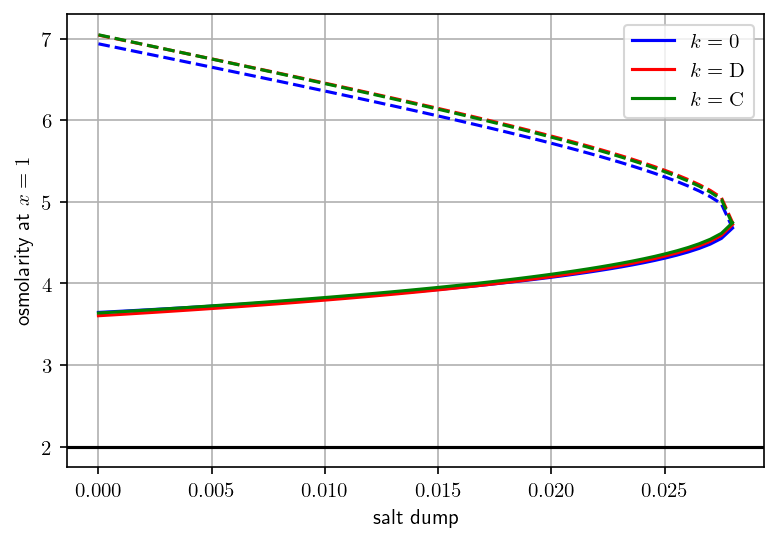

In [ ]:
# Plotting osmolarity
# n = np.linspace(0.01,0.028,num=10)
n = np.linspace(0,0.028,num=58)
compartments = ['0','\mathrm{D}','\mathrm{C}']
colors = ['b','r','g']
osm = [output_osm_0,output_osm_C,output_osm_D]
bw_osm = [bw_osm_0,bw_osm_D,bw_osm_C]

fig, ax = plt.subplots()
plt.rcParams['text.usetex'] = True
ax.grid(True, which='both')
ax.axhline(y=2, color='k')
for k in range(3):
    ax.plot(n,osm[k],label=r'$k={}$'.format(compartments[k]),color=colors[k])
    ax.plot(n,bw_osm[k],colors[k]+'--')
ax.legend()
plt.xlabel(r"salt dump")
plt.ylabel(r"osmolarity at $x=1$")
plt.show

In [ ]:
# np.save('./unstable.npy',y)

In [144]:
y[:] = np.load('./4fluxes_1nephron_max.npy')
# y[:] = np.load('./unstable.npy')
y_init[:] = y.copy()

# Transport parameters
# demo: 2,4,10,10,0.1
s_perm = 1.2
u_perm_val = 1.2
w_D_perm = 10
w_C_perm = 10
S_input = 0.8
U_input = 2
osm_input = 2
u_frac = 1
# s_dump = 0
s_dump = 0.0285

y[:] = fsolve(res,y_init,maxfev=500*6*(N+1))
q_0 = avg(q_out) - avg(q_C) - avg(q_A) - avg(q_D)
S_0 = S[-1] - avg(S)
U_0 = U[-1] - avg(U)
osm_0 = (2*S_0+U_0)/q_0
osm_C = U/q_C
osm_D = 2*S_input/q_D
osm_A = 2*S/q_A
# s_nodump = S_0/q_0
# u_nodump = U_0/q_0
s_dump = S_0/q_0
u_dump = U_0/q_0

<function matplotlib.pyplot.show(close=None, block=None)>

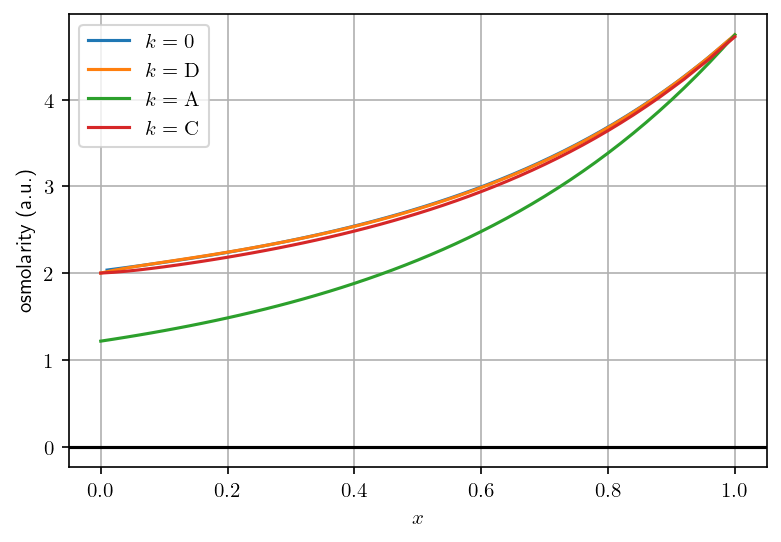

In [145]:
# Plotting osmolarity
x = np.linspace(0,1,num=N+1)
x_avg = np.linspace(dx/2,1-dx/2,num=N)
compartments = ['0','\mathrm{D}','\mathrm{A}','\mathrm{C}']
osm = [osm_0,osm_D,osm_A,osm_C]

fig, ax = plt.subplots()
plt.rcParams['text.usetex'] = True
ax.grid(True, which='both')
ax.axhline(y=0, color='k')
for k in range(4):
    if k==0:
        ax.plot(x_avg,osm[0],label=r'$k={}$'.format(compartments[k]))
    else:
        ax.plot(x,osm[k],label=r'$k={}$'.format(compartments[k]))
ax.legend()
plt.xlabel(r"$x$")
plt.ylabel(r"osmolarity (a.u.)")
plt.show

Now, we want to compare salt and urea concentration in the central core.

<function matplotlib.pyplot.show(close=None, block=None)>

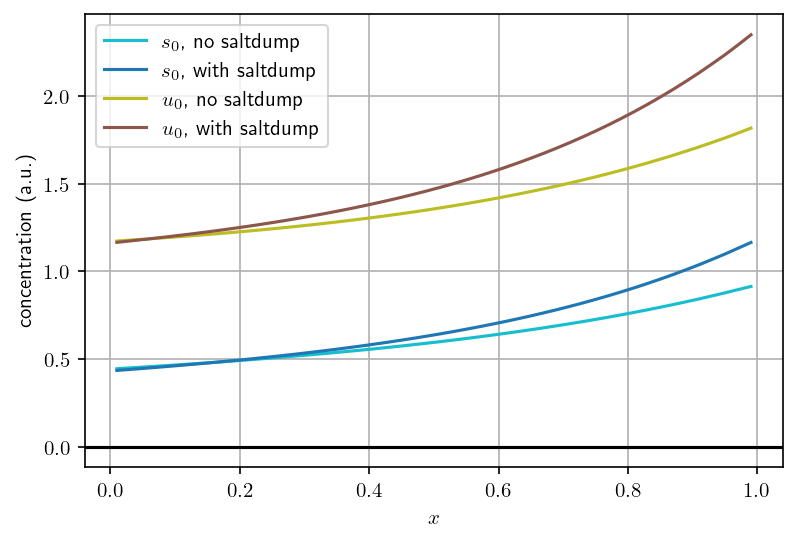

In [147]:
# Plotting osmolarity
x_avg = np.linspace(dx/2,1-dx/2,num=N)

fig, ax = plt.subplots()
plt.rcParams['text.usetex'] = True
ax.grid(True, which='both')
ax.axhline(y=0, color='k')
ax.plot(x_avg,s_nodump,label=r'$s_0$, no saltdump', color='tab:cyan')
ax.plot(x_avg,s_dump,label=r'$s_0$, with saltdump', color='tab:blue')
ax.plot(x_avg,u_nodump,label=r'$u_0$, no saltdump', color='tab:olive')
ax.plot(x_avg,u_dump,label=r'$u_0$, with saltdump', color='tab:brown')
ax.legend()
plt.xlabel(r"$x$")
plt.ylabel(r"concentration (a.u.)")
plt.show

Let us re-explore the parameter space for the 'unstable branch' of the solution.

In [194]:
end_osm_0 = np.zeros((12,12))
end_osm_C = np.zeros((12,12))
end_osm_D = np.zeros((12,12))
# y[:] = np.load('./4fluxes_1nephron_max.npy')
y[:] = np.load('./unstable.npy')

# Transport parameters
w_D_perm = 10
w_C_perm = 10
S_input = 0.8
U_input = 2
osm_input = 2
s_dump = 0
for i in range(12):
    y_init[:] = y.copy()
    for j in range(12):
        # u_perm_val = .1*(i+1)
        u_perm_val = 1.2 - .02*i
        # if (i%2)==0:
        # s_perm = .1*(j+1)
        s_perm = 1.2 - .02*j
        # else:
            # s_perm = .1*(10-j)
        

        y[:] = fsolve(res,y_init,maxfev=500*6*(N+1))
        q_0 = avg(q_out) - avg(q_C) - avg(q_A) - avg(q_D)
        S_0 = S[-1] - avg(S)
        U_0 = U[-1] - avg(U)
        end_osm_0[11-i,11-j] = (2*S_0[-1]+U_0[-1])/q_0[-1]
        end_osm_C[11-i,11-j] = U[-1]/q_C[-1]
        end_osm_D[11-i,11-j] = 2*S_input/q_D[-1]

In [197]:
nodump_osm_0 = np.zeros((12,12))
nodump_osm_C = np.zeros((12,12))
nodump_osm_D = np.zeros((12,12))
y[:] = np.load('./4fluxes_1nephron.npy')

y_init[:] = y.copy()
# Transport parameters
for i in range(12):
    for j in range(12):
        u_perm = 0.96 + .02*(i+1)
        # if (i%2)==0:
        s_perm = 0.96 + .02*(j+1)
        # else:
            # s_perm = .1*(10-j)
        w_D_perm = 10
        w_C_perm = 10
        S_input = 1
        U_input = 2
        osm_input = 2

        y[:] = fsolve(res,y_init,maxfev=500*6*(N+1))
        q_0 = avg(q_out) - avg(q_C) - avg(q_A) - avg(q_D)
        S_0 = S[-1] - avg(S)
        U_0 = U[-1] - avg(U)
        nodump_osm_0[i,j] = (2*S_0[-1]+U_0[-1])/q_0[-1]
        nodump_osm_C[i,j] = U[-1]/q_C[-1]
        nodump_osm_D[i,j] = 2*S_input/q_D[-1]

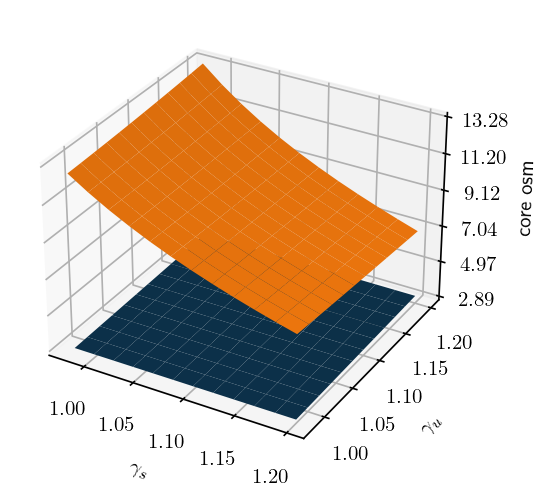

In [199]:
# Plotting end osmolarity against u_perm,s_perm
from matplotlib.ticker import LinearLocator
u_space = np.linspace(0.98,1.2,num=12)
s_space = np.linspace(0.98,1.2,num=12)
u_space, s_space = np.meshgrid(u_space, s_space)

ax = plt.figure().add_subplot(projection='3d')

surf_nodump = ax.plot_surface(s_space,u_space,nodump_osm_0)
surf_dump = ax.plot_surface(s_space,u_space,end_osm_0)
plt.rcParams['text.usetex'] = True
plt.xlabel(r"$\gamma_s$")
plt.ylabel(r"$\gamma_u$")
ax.zaxis.set_major_locator(LinearLocator(6))
ax.set_zlabel(r"core osm")
plt.show()

In [337]:
a = 1.27

In [338]:
# y[:] = np.load('./4fluxes_1nephron_max.npy')
# y[:] = np.load('./unstable.npy')
y_init[:] = y.copy()

# Transport parameters
# demo: 2,4,10,10,0.1
s_perm = a
u_perm_val = a
w_D_perm = 10
w_C_perm = 10
S_input = 0.8
U_input = 2
osm_input = 2
u_frac = 1
s_dump = 0
# s_dump = 0.0285

y[:] = fsolve(res,y_init,maxfev=500*6*(N+1))
q_0 = avg(q_out) - avg(q_C) - avg(q_A) - avg(q_D)
S_0 = S[-1] - avg(S)
U_0 = U[-1] - avg(U)
osm_0 = (2*S_0+U_0)/q_0
osm_C = U/q_C
osm_D = 2*S_input/q_D
osm_A = 2*S/q_A

<function matplotlib.pyplot.show(close=None, block=None)>

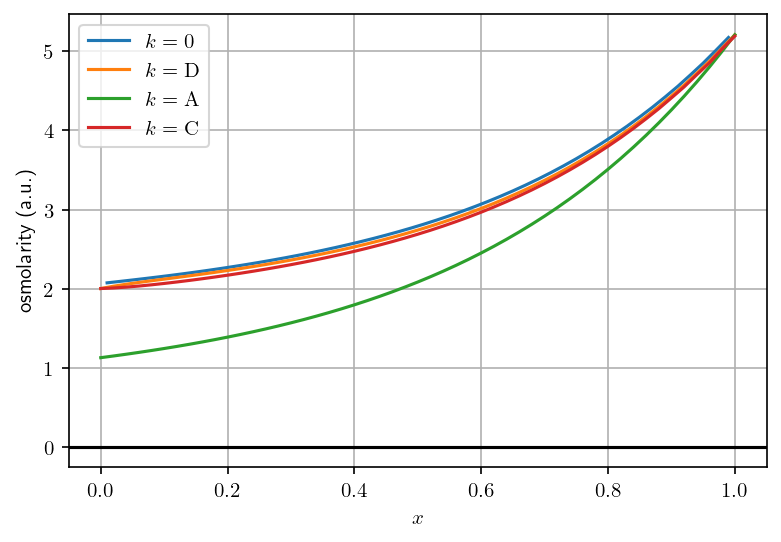

In [339]:
# Plotting osmolarity
x = np.linspace(0,1,num=N+1)
x_avg = np.linspace(dx/2,1-dx/2,num=N)
compartments = ['0','\mathrm{D}','\mathrm{A}','\mathrm{C}']
osm = [osm_0,osm_D,osm_A,osm_C]

fig, ax = plt.subplots()
plt.rcParams['text.usetex'] = True
ax.grid(True, which='both')
ax.axhline(y=0, color='k')
for k in range(4):
    if k==0:
        ax.plot(x_avg,osm[0],label=r'$k={}$'.format(compartments[k]))
    else:
        ax.plot(x,osm[k],label=r'$k={}$'.format(compartments[k]))
ax.legend()
plt.xlabel(r"$x$")
plt.ylabel(r"osmolarity (a.u.)")
plt.show

In [340]:
# x = np.linspace(0,1,num=N+1)
# x_avg = np.linspace(dx/2,1-dx/2,num=N)
# compartments = ['0','\mathrm{D}','\mathrm{A}','\mathrm{C}']
# osm = [osm_0,osm_D,osm_A,osm_C]

# fig, ax = plt.subplots()
# plt.rcParams['text.usetex'] = True
# ax.grid(True, which='both')
# ax.axhline(y=0, color='k')
# ax.plot(x,U,label=r'$\alpha_Cu_C$')
# ax.plot(x,q_C,label=r'$q_C$')
# ax.legend()
# plt.xlabel(r"$x$")
# plt.ylabel(r"osmolarity (a.u.)")
# plt.show